# Train an anti-aliased U-net based GAN

## Imports

In [158]:
import tensorflow as tf
import os
from PIL import Image
from scipy import special
import numpy as np
from matplotlib import pyplot as plt

## Anti-aliasing filter

Kernel:


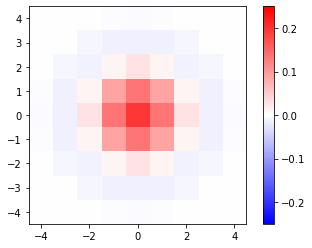

Frequency response:


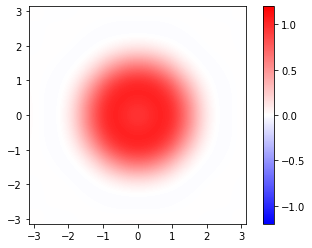

In [159]:
oversampling = 2  # Oversampling factor, 2 is a good choice
aa_kernel_w = 9  # Horizontal size of the kernel, also its vertical size. Must be odd. 9 is a good choice when oversampling == 2.

def circularLowpassKernel(omega_c, N):  # omega = cutoff frequency in radians (pi is max), N = horizontal size of the kernel, also its vertical size, must be odd.
  with np.errstate(divide='ignore',invalid='ignore'):    
      kernel = np.fromfunction(lambda x, y: omega_c*special.j1(omega_c*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2))/(2*np.pi*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2)), [N, N])
  kernel[(N - 1)//2, (N - 1)//2] = omega_c**2/(4*np.pi)
  return kernel 

def rotatedCosineWindow(N):  # N = horizontal size of the targeted kernel, also its vertical size, must be odd.
  return np.fromfunction(lambda y, x: np.maximum(np.cos(np.pi/2*np.sqrt(((x - (N - 1)/2)/((N - 1)/2 + 1))**2 + ((y - (N - 1)/2)/((N - 1)/2 + 1))**2)), 0), [N, N])

aa_kernel_cutoff_pi = circularLowpassKernel(np.pi/oversampling, aa_kernel_w)*rotatedCosineWindow(aa_kernel_w)

print("Kernel:")
plt.imshow(windowedkernel_cutoff_pi, vmin=-0.25, vmax=0.25, cmap='bwr', extent=[-aa_kernel_w/2, aa_kernel_w/2, -aa_kernel_w/2, aa_kernel_w/2])
plt.colorbar()
plt.show()

print("Frequency response:")
freq_resp = np.real(np.fft.fftshift(np.fft.fft2(np.roll(np.pad(windowedkernel_cutoff_pi, 100, mode = 'constant', constant_values = 0), shift = (-aa_kernel_w//2-99, -aa_kernel_w//2-99), axis = (0, 1)))))
plt.imshow(freq_resp, vmin=-1.2, vmax=1.2, cmap='bwr', extent=[-np.pi, np.pi, -np.pi, np.pi])
plt.colorbar()
plt.show()

aa_kernel_cutoff_pi = tf.repeat(tf.expand_dims(tf.constant(aa_kernel_cutoff_pi, dtype=tf.float32), 2), 3, axis=2)
aa_kernel_cutoff_pi = tf.expand_dims(aa_kernel_cutoff_pi, -1) # (height, width, output channels, input channels)

## Load target photos

In [167]:
photos_dir = "D:/roman/source_grass_images"
save_filtered_photos_dir = "D:/roman/filtered_grass_images" # save folder, or None to disable saving

for filename in list(os.walk(photos_dir))[0][2]:
    image = tf.io.decode_png(tf.io.read_file(photos_dir + "/" + filename), channels=3, dtype=tf.dtypes.uint8)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) # * 2 - 1
    image = tf.nn.depthwise_conv2d([image], aa_kernel_cutoff_pi, [1, 1, 1, 1], "VALID")[0]
    if save_filtered_photos_dir is not None:
        tf.io.write_file(save_filtered_photos_dir + "/" + filename, tf.io.encode_png(tf.image.convert_image_dtype(image, dtype=tf.dtypes.uint8, saturate=True)))
    

## TODO a lot of stuff....